In [39]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import pandas as pd
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True

In [40]:
from torch.utils.data import Dataset, random_split
from torchvision.io import read_image
from tqdm.notebook import tqdm

In [56]:
import wandb

wandb.init(project="FairFaceClassification", entity="arshpreet", name='resnet50_32_5')

In [57]:
wandb.config = {
  "backbone": 'resnet50',
  "extra-layers": 'none',
  "learning_rate": 0.001,
  "epochs": 5,
  "batch_size": 32
}

In [58]:
from sklearn.preprocessing import LabelEncoder
label_encoder1 = LabelEncoder()
label_encoder2 = LabelEncoder()
label_encoder3 = LabelEncoder()

In [59]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(244),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [60]:
class FairFaceDataset(Dataset):
    """
    Class for preprocessing data
    Input: Dataset
    Functionality: Label encodes the predictive labels and processes images from the dataset
    Returns: processed labels and images
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        '''
        Does required encoding of labels
        '''
        self.img_labels = pd.read_csv(annotations_file)
        self.img_labels['age'] = label_encoder1.fit_transform(self.img_labels['age'])
        self.img_labels['gender'] = label_encoder2.fit_transform(self.img_labels['gender'])
        self.img_labels['race'] = label_encoder3.fit_transform(self.img_labels['race'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        '''
        returns length of the image labels
        '''
        return len(self.img_labels)

    def __getitem__(self, idx):
        '''
        extracts images and returns the image along with the corresponding labels
        '''
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        age = self.img_labels.iloc[idx, 1]
        gender = self.img_labels.iloc[idx, 2]
        race = self.img_labels.iloc[idx, 3]
        if self.transform:
            image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        labels = (age, gender, race)
        return image, labels

In [61]:
img_dir = '../fairface-data'
train_labels_path = "../fairface-data/fairface_label_train.csv"
val_labels_path = "../fairface-data/fairface_label_val.csv"

In [62]:
training_data = FairFaceDataset(train_labels_path, img_dir, transform=transform)
val_data = FairFaceDataset(val_labels_path, img_dir, transform=transform)

In [63]:
train_size, val_size = len(training_data), len(val_data)
print(train_size, val_size)

86744 10954


In [43]:
training_data[0]

(tensor([[[-1.9809, -1.9638, -1.9467,  ..., -1.3473, -1.3473, -1.3473],
          [-1.9980, -1.9809, -1.9638,  ..., -1.3987, -1.4158, -1.4158],
          [-2.0152, -2.0152, -1.9809,  ..., -1.5014, -1.5185, -1.5185],
          ...,
          [-1.4158, -1.4158, -1.3987,  ..., -1.7754, -1.7583, -1.7754],
          [-1.4500, -1.4500, -1.4843,  ..., -1.7583, -1.7412, -1.7412],
          [-1.4843, -1.4843, -1.5185,  ..., -1.7069, -1.7240, -1.7240]],
 
         [[-1.8957, -1.8782, -1.8957,  ..., -1.5805, -1.6155, -1.6155],
          [-1.9132, -1.8957, -1.9132,  ..., -1.5980, -1.6331, -1.6331],
          [-1.9307, -1.9307, -1.9307,  ..., -1.6155, -1.6331, -1.6331],
          ...,
          [-1.5980, -1.5980, -1.5630,  ..., -1.7381, -1.7206, -1.6856],
          [-1.5630, -1.5630, -1.5630,  ..., -1.7206, -1.7031, -1.6856],
          [-1.5805, -1.5805, -1.5805,  ..., -1.6856, -1.6681, -1.6681]],
 
         [[-1.6302, -1.6127, -1.6127,  ..., -1.4559, -1.4384, -1.4384],
          [-1.6476, -1.6302,

In [48]:
def get_label_names(labels):
    '''
    gets true labels corresponding to the encoded values
    '''
    age, gender, race = labels
    age = label_encoder1.inverse_transform(age)
    gender = label_encoder2.inverse_transform(gender)
    race = label_encoder3.inverse_transform(race)
    return age, gender, race

In [67]:
image_datasets = {'train': training_data,
                  'val': val_data}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 244, 244])


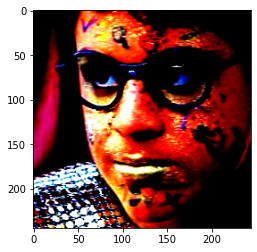

(array(['10-19'], dtype=object), array(['Male'], dtype=object), array(['Middle Eastern'], dtype=object))


In [68]:
inputs, labels = next(iter(dataloaders['train']))
print(f"Feature batch shape: {inputs.size()}")
label_names = get_label_names(x[0].unsqueeze(0) for x in labels)
img = inputs[0].squeeze()
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(label_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


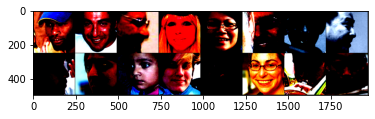

In [51]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.pause(0.001) 

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [52]:
get_label_names(classes)

(array(['30-39', '20-29', '40-49', '30-39', '40-49', '40-49', '10-19',
        '40-49', '10-19', '20-29', '3-9', '20-29', '30-39', '30-39',
        '10-19', '10-19'], dtype=object),
 array(['Male', 'Male', 'Male', 'Female', 'Female', 'Male', 'Male', 'Male',
        'Female', 'Female', 'Female', 'Female', 'Male', 'Female', 'Male',
        'Male'], dtype=object),
 array(['Black', 'Middle Eastern', 'Middle Eastern', 'White', 'East Asian',
        'Indian', 'Indian', 'East Asian', 'Latino_Hispanic', 'Indian',
        'Indian', 'White', 'Middle Eastern', 'White', 'Latino_Hispanic',
        'Southeast Asian'], dtype=object))

In [69]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    '''
    for defining the training and validation loop of the model
    and logging the experiments
    '''
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            age_acc, gender_acc, race_acc = (0.0,0.0,0.0)

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.float().to(device)
                label1 = labels[0].to(device)
                label2 = labels[1].to(device)
                label3 = labels[2].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    op1, op2, op3 = model(inputs)
                    loss = criterion(op1, label1) \
                         + criterion(op2, label2) \
                         + criterion(op3, label3)

                    y_pred = [torch.argmax(torch.softmax(out, dim=1), dim=1) for out in (op1,op2,op3)]
                    age_acc += torch.sum(label1 == y_pred[0])
                    gender_acc += torch.sum(label2 == y_pred[1])
                    race_acc += torch.sum(label3 == y_pred[2])

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            age_acc /= dataset_sizes[phase]
            gender_acc /= dataset_sizes[phase]
            race_acc /= dataset_sizes[phase]

            if phase=='train':
                wandb.log({"Epoch Loss for train": epoch_loss,
                        "Age Accuracy for train": age_acc,
                        "Gender Accuracy for train": gender_acc,
                        "Race Accuracy for train": race_acc}
                        )
            else:
                wandb.log({"Epoch Loss for val": epoch_loss,
                        "Age Accuracy for val": age_acc,
                        "Gender Accuracy for val": gender_acc,
                        "Race Accuracy for val": race_acc}
                        )

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            print('{} Accuracy- Age: {:.2f}, Gender: {:.2f}, Race: {:.2f}'.format(
                phase, age_acc, gender_acc, race_acc))

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model

## ResNet 50

In [70]:
class MultiTaskClassifier(nn.Module):
    '''
    Building the architecture of the pre-trained backbone
    '''
    def __init__(self):
        '''
        defining the fully-connected layers added on top of the backbone
        '''
        super().__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.num_ftrs = self.resnet50.fc.out_features
        self.op1 = nn.Linear(self.num_ftrs, 9)
        self.op2 = nn.Linear(self.num_ftrs, 2)
        self.op3 = nn.Linear(self.num_ftrs, 7)

    def forward(self, x):
        '''
        for returning the label values predicted by the model
        '''
        x = self.resnet50(x)
        age = self.op1(x)
        gender = self.op2(x)
        race = self.op3(x)
        return (age, gender, race)

In [71]:
model = MultiTaskClassifier().cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [49]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


  0%|          | 0/5422 [00:00<?, ?it/s]

train Loss: 3.9622
train Accuracy- Age: 0.34, Gender: 0.67, Race: 0.33


  0%|          | 0/685 [00:00<?, ?it/s]

val Loss: 3.3551
val Accuracy- Age: 0.39, Gender: 0.77, Race: 0.46

Epoch 1/4
----------


  0%|          | 0/5422 [00:00<?, ?it/s]

train Loss: 3.0883
train Accuracy- Age: 0.43, Gender: 0.81, Race: 0.49


  0%|          | 0/685 [00:00<?, ?it/s]

val Loss: 2.8455
val Accuracy- Age: 0.47, Gender: 0.84, Race: 0.53

Epoch 2/4
----------


  0%|          | 0/5422 [00:00<?, ?it/s]

train Loss: 2.7059
train Accuracy- Age: 0.48, Gender: 0.86, Race: 0.55


  0%|          | 0/685 [00:00<?, ?it/s]

val Loss: 2.6410
val Accuracy- Age: 0.49, Gender: 0.86, Race: 0.57

Epoch 3/4
----------


  0%|          | 0/5422 [00:00<?, ?it/s]

train Loss: 2.4894
train Accuracy- Age: 0.51, Gender: 0.88, Race: 0.59


  0%|          | 0/685 [00:00<?, ?it/s]

val Loss: 2.4373
val Accuracy- Age: 0.52, Gender: 0.89, Race: 0.60

Epoch 4/4
----------


  0%|          | 0/5422 [00:00<?, ?it/s]

train Loss: 2.3233
train Accuracy- Age: 0.53, Gender: 0.89, Race: 0.62


  0%|          | 0/685 [00:00<?, ?it/s]

val Loss: 2.4457
val Accuracy- Age: 0.50, Gender: 0.89, Race: 0.62

Training complete in 45m 18s
Best val loss: 2.437296


In [72]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


  0%|          | 0/2711 [00:00<?, ?it/s]

train Loss: 3.3926
train Accuracy- Age: 0.40, Gender: 0.77, Race: 0.43


  0%|          | 0/343 [00:00<?, ?it/s]

val Loss: 2.9894
val Accuracy- Age: 0.47, Gender: 0.84, Race: 0.50

Epoch 1/4
----------


  0%|          | 0/2711 [00:00<?, ?it/s]

train Loss: 2.7194
train Accuracy- Age: 0.48, Gender: 0.86, Race: 0.55


  0%|          | 0/343 [00:00<?, ?it/s]

val Loss: 2.6262
val Accuracy- Age: 0.50, Gender: 0.88, Race: 0.56

Epoch 2/4
----------


  0%|          | 0/2711 [00:00<?, ?it/s]

train Loss: 2.4437
train Accuracy- Age: 0.51, Gender: 0.89, Race: 0.60


  0%|          | 0/343 [00:00<?, ?it/s]

val Loss: 2.4318
val Accuracy- Age: 0.51, Gender: 0.90, Race: 0.60

Epoch 3/4
----------


  0%|          | 0/2711 [00:00<?, ?it/s]

train Loss: 2.2558
train Accuracy- Age: 0.54, Gender: 0.90, Race: 0.63


  0%|          | 0/343 [00:00<?, ?it/s]

val Loss: 2.5511
val Accuracy- Age: 0.54, Gender: 0.88, Race: 0.60

Epoch 4/4
----------


  0%|          | 0/2711 [00:00<?, ?it/s]

train Loss: 2.0957
train Accuracy- Age: 0.56, Gender: 0.92, Race: 0.66


  0%|          | 0/343 [00:00<?, ?it/s]

val Loss: 2.3416
val Accuracy- Age: 0.53, Gender: 0.90, Race: 0.62

Training complete in 41m 49s
Best val loss: 2.341624


In [78]:
PATH = "models/resnet50_32.pth"

In [76]:
torch.save(model_ft.state_dict(), PATH)

In [79]:
testmodel = MultiTaskClassifier().cuda()
testmodel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [88]:
next(iter(dataloaders['val']))[0][0].unsqueeze(0).shape

torch.Size([1, 3, 244, 244])

In [90]:
output = testmodel(next(iter(dataloaders['val']))[0][0].unsqueeze(0).cuda())

In [91]:
output

(tensor([[-12.9845,   0.5151,   2.6188,  -3.8232,   2.6869,   1.7755,  -1.3072,
           -5.9720, -10.9508]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[-1.5503,  1.6068]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[-0.9564, -3.3385,  0.1673,  2.6150, -0.3810, -1.0186, -0.6816]],
        device='cuda:0', grad_fn=<AddmmBackward0>))